<a href="https://colab.research.google.com/github/badruzbby/project-data-analyst/blob/main/News_Sentiment_vs_Stock_Price_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
import re
import time
import requests
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from transformers import pipeline
from datetime import datetime, timedelta
from bs4 import BeautifulSoup

In [2]:
def parse_relative_time(text):
    now = datetime.now()

    if "jam yang lalu" in text:
        hours = int(re.findall(r"\d+", text)[0])
        return now - timedelta(hours=hours)

    elif "hari yang lalu" in text:
        days = int(re.findall(r"\d+", text)[0])
        return now - timedelta(days=days)

    elif "bulan yang lalu" in text:
        months = int(re.findall(r"\d+", text)[0])
        return now - timedelta(days=30*months)

    elif "menit yang lalu" in text:
        minutes = int(re.findall(r"\d+", text)[0])
        return now - timedelta(minutes=minutes)

    else:
        try:
            return datetime.strptime(text, "%d %B %Y %H:%M")
        except:
            return now


Function untuk scraping CNBC

In [3]:
def scrape_cnbc(pages=5):
    """
    Scraping berita dari CNBC Indonesia bagian market
    :param pages: jumlah halaman yang mau discan
    :return: DataFrame berita (judul, link, waktu)
    """
    base_url = "https://www.cnbcindonesia.com/market/indeks/5?page={}"
    headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Safari/537.36 Edg/137.0.0.0"}

    all_data = []

    for i in range(1, pages+1):
        url = base_url.format(i)
        req = requests.get(url, headers=headers)
        soup = BeautifulSoup(req.content, "lxml")

        # Judul berita
        titles = [t.get_text(strip=True) for t in soup.find_all("h2", class_="font-semibold group-hover:text-cnbc-primary-blue dark:text-white text-23")]

        # Link berita
        links = [a["href"] for a in soup.find_all("a", class_="group flex gap-4 items-center")]

        # Waktu posting berita (misal: '2 jam yang lalu', '1 hari yang lalu')
        times = [span.get_text(strip=True) for span in soup.find_all("span", class_="text-xs text-gray")]

        for t, l, tm in zip(titles, links, times):
            all_data.append({"headlines": t, "links": l, "time_posted": parse_relative_time(tm)})

        time.sleep(1)  # delay biar aman

    return pd.DataFrame(all_data)

Ambil Data Berita CNBC

In [4]:
news_df = scrape_cnbc(pages=90)
print("Total berita terkumpul:", len(news_df))
news_df.head()

Total berita terkumpul: 900


,headlines,links,time_posted
0,Daftar 10 Orang Terkaya Dunia per 30 Agustus 2...,https://www.cnbcindonesia.com/market/202508301...,2025-08-30 05:01:30.607059
1,"Robert Kiyosaki Buka Rahasia, 3 Aset Ini Jadi ...",https://www.cnbcindonesia.com/market/202508300...,2025-08-30 02:14:30.607122
2,10 Manajer Investasi Didakwa Bantu Asabri Gore...,https://www.cnbcindonesia.com/market/202508291...,2025-08-29 14:14:30.607136
3,OJK Luncurkan Sistem Perizinan Pasar Modal ke ...,https://www.cnbcindonesia.com/market/202508291...,2025-08-29 12:14:30.607144
4,"Heboh Video Massa di Menara BNI Pejompongan, M...",https://www.cnbcindonesia.com/market/202508291...,2025-08-29 11:14:30.607151


Sentiment Analysis (RoBERTa Indonesia)

In [5]:
classifier = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier")

def get_sentiment(text):
    try:
        result = classifier(text[:512])
        label = result[0]['label']
        score = result[0]['score']
        return label, score
    except Exception as e:
        return "error", 0.0

news_df[["sentiment_label", "sentiment_score"]] = news_df["headlines"].apply(
    lambda x: pd.Series(get_sentiment(str(x)))
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


Ambil Data Saham dari Yahoo Finance

In [6]:
ticker = "^JKSE"  # IHSG
stock = yf.download(ticker, period="1mo", interval="1d")
stock = stock.rename(columns={"Close":"close_price"})

/tmp/ipython-input-3257818858.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, period="1mo", interval="1d")
[*********************100%***********************]  1 of 1 completed


 Gabungkan Data (Berita + Saham)

In [9]:
# Reset index untuk membuat kolom 'Date'
stock = stock.reset_index()
stock["Date"] = pd.to_datetime(stock["Date"])

# Sebelum menggabungkan, pastikan 'saham' hanya memiliki indeks level tunggal
# mengatur kolom 'Tanggal' sebagai indeks setelah mengatur ulang
stock_for_merge = stock.set_index('Date')

# Drop kolom multi-level
stock_for_merge.columns = stock_for_merge.columns.droplevel(level=0)

# Pastikan 'time_posted' adalah datetime dan ekstrak tanggal untuk penggabungan
news_df['time_posted'] = pd.to_datetime(news_df['time_posted'])
news_df['date'] = news_df['time_posted'].dt.date
# Mengonversi kolom 'tanggal' di news_df menjadi objek datetime
news_df['date'] = pd.to_datetime(news_df['date'])


# Merge: left join berdasarkan tanggal
merged_df = pd.merge(news_df, stock_for_merge, left_on='date', right_index=True, how="left")

display(merged_df.head())

,headlines,links,time_posted,sentiment_label,sentiment_score,date,,^JKSE,^JKSE,^JKSE,^JKSE,^JKSE
0,Daftar 10 Orang Terkaya Dunia per 30 Agustus 2...,https://www.cnbcindonesia.com/market/202508301...,2025-08-30 05:01:30.607059,negative,0.838680,2025-08-30,NaN,NaN,NaN,NaN,NaN,NaN
1,"Robert Kiyosaki Buka Rahasia, 3 Aset Ini Jadi ...",https://www.cnbcindonesia.com/market/202508300...,2025-08-30 02:14:30.607122,neutral,0.995024,2025-08-30,NaN,NaN,NaN,NaN,NaN,NaN
2,10 Manajer Investasi Didakwa Bantu Asabri Gore...,https://www.cnbcindonesia.com/market/202508291...,2025-08-29 14:14:30.607136,neutral,0.998899,2025-08-29,22.0,7830.493164,7913.859863,7765.596191,7899.887207,481348100.0
3,OJK Luncurkan Sistem Perizinan Pasar Modal ke ...,https://www.cnbcindonesia.com/market/202508291...,2025-08-29 12:14:30.607144,neutral,0.999022,2025-08-29,22.0,7830.493164,7913.859863,7765.596191,7899.887207,481348100.0
4,"Heboh Video Massa di Menara BNI Pejompongan, M...",https://www.cnbcindonesia.com/market/202508291...,2025-08-29 11:14:30.607151,neutral,0.994802,2025-08-29,22.0,7830.493164,7913.859863,7765.596191,7899.887207,481348100.0


In [10]:
merged_df.to_csv("cnbc_sentiment_stock.csv", index=False, encoding="utf-8-sig")
print("✅ Data berhasil disimpan ke cnbc_sentiment_stock.csv")

✅ Data berhasil disimpan ke cnbc_sentiment_stock.csv


Visualisasi Data

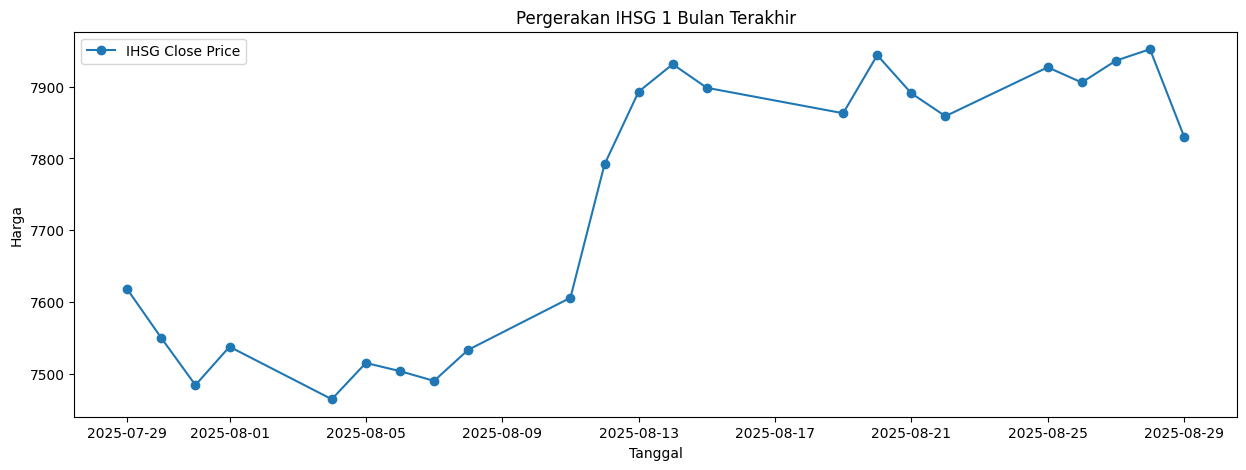

In [13]:
plt.figure(figsize=(15,5))
plt.plot(stock["Date"], stock["close_price"], marker="o", label="IHSG Close Price")
plt.title("Pergerakan IHSG 1 Bulan Terakhir")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.legend()
plt.show()

Distribusi Sentimen

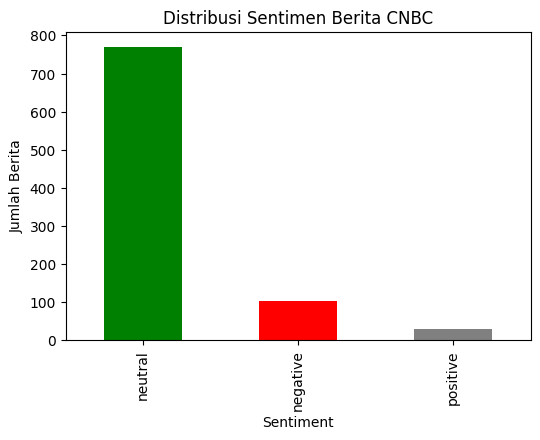

In [12]:
plt.figure(figsize=(6,4))
news_df["sentiment_label"].value_counts().plot(kind="bar", color=["green","red","gray"])
plt.title("Distribusi Sentimen Berita CNBC")
plt.xlabel("Sentiment")
plt.ylabel("Jumlah Berita")
plt.show()